This section uses Twitter and EDGAR server log data to construct a graph of the time series of investor attention on each platform.

The first code snippet imports the libraries needed to construct the graph. Imports evolved from the C programming language in which used a concept similar to imports (include in C) to minimize the size of code. A simple program with all available python code might be in the terabytes range, whereas a program that uses only what is needed would be in the kilobytes/megabytes range.

In [19]:
import json
import pytz
import pandas as pd
from dateutil import parser
from collections import defaultdict
from matplotlib import pyplot as plt


This step provides the setup for parsing the Twitter data. The variable orcl_json references the location of the Twitter posts for Oracle from 6/1/2015 to 8/1/2015. Computers communicate using Greenwich Mean Time (GMT, also known as z-time); Twitter data, unlike most US financial data, is on GMT basis. We later use the variable tz to translate the timezone from GMT to Eastern.

The default dictionaries orcl_ct and orcl_ct2 make it less unwieldy to add the data to construct the graph. This could also be done with the dictionary type, but a check for the existence of a key would be required. For example:

orcl_ct = defaultdict(set)
orcl_ct[date_est].add(j['user']['id_str'])

vs.

orcl_ct = {}
if date_est in orcl_ct:
    orcl_ct[date_est].add(j['user']['id_str'])
else:
    orcl_ct[date_est] = set((j['user']['id_str']))


Earnings were announced on 6/17/2015

In [20]:
# Address of json file with $ORCL posts
orcl_json = 'in/twtr2015orcl.json'

# Used to convert time zone from GMT to Eastern 
tz = pytz.timezone('US/Eastern') 

# Used to count links to sec.gov for ORCL
orcl_ct = defaultdict(set)
orcl_ct2 = defaultdict(lambda: 0)

To get Twitter's JSON data into a more managable tabular format, the file needs to be parsed from JSON. The json library is used to parse text from a file into a dictionary-like object. 

Use json.dumps(j, indent=2) to examine a single record. Use the command break to terminate a for loop:
for i in f:
    j = json.loads(i)
    print(json.dumps(j, indent=2))
    break

In [21]:
with open(orcl_json,encoding='utf8') as f:
    for i in f:
        j = json.loads(i)
        date_ztime = parser.parse(j['created_at'])
        # translate GMT (also called Z-time) to date with EST timezone reference to connect to US market data
        date_est = date_ztime.astimezone(tz).date()

        # Use this to get the number of users posting
        orcl_ct[date_est].add(j['user']['id_str'])
        
        # Use this to get the number of posts
        orcl_ct2[date_est] += 1

The variable orcl_ct now has a set of users for each day. A set does not have duplicate records, so the length of this list gives the number of unique users in a given day.

In [22]:
orcl_numusers = {}
for i in orcl_ct: orcl_numusers[i] = len(orcl_ct[i])

Load the parsed data to a Pandas DataFrame to make merging easier. This can also be done with a database on the backend for larger files.

In [23]:
# Make a DataFrame with the number of users for each day using Twitter data
df_twtr = pd.DataFrame(data=orcl_numusers.items(),columns=['date','numusers'])

#convert from date to datetime for merge
df_twtr['date'] = pd.to_datetime(df_twtr['date'])

# Make a DataFrame with the number of posts for each day using Twitter data
# df_twtr = pd.DataFrame(data=orcl_ct2.items(),columns=['date','numposts'])

Load data from EDGAR logs and merge with Twitter data.

In [24]:
edgar_file_loc = 'in/edgar2015.csv'

# Read file with counts of algorithmic and non-algortihmic EDGAR veiws for the firm associated with $ORCL stock 
df_edgar = pd.read_csv(edgar_file_loc)
df_edgar['date'] = pd.to_datetime(df_edgar['date'], format='%m/%d/%Y')

# Merge the two files
df = pd.merge(df_edgar,df_twtr, how='left', on = 'date')

Make the graph.

Text(0.5, 1.0, 'Non-algorithmic EDGAR Views and Twitter Attention')

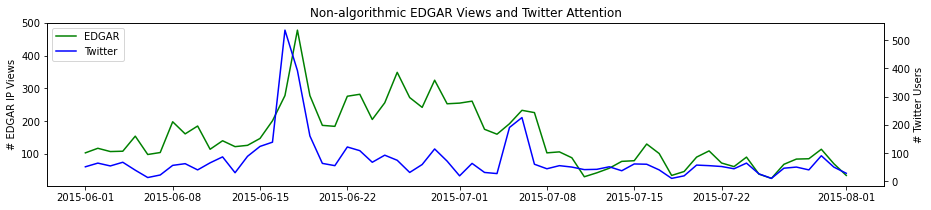

In [25]:
# Make a plot of EDGAR views and Twitter attention 
fig, ax1 = plt.subplots(figsize=(15,3))
ax1.plot(df['date'], df['noalgo_ct'], color = 'green', label='EDGAR')
ax1.set_ylabel('# EDGAR IP Views')
ax2 = ax1.twinx()
ax2.plot(df['date'], df['numusers'], color='blue', label='Twitter')
ax2.set_ylabel('# Twitter Users')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
plt.title('Non-algorithmic EDGAR Views and Twitter Attention')